## River and Spring Discharge:
### Hillsborough River at Crystal Springs near Zephyrhills, FL
This iPython Notebook is used to compute spring discharge for Crystal Springs from stream discharge data downloaded from NWIS Web (https://waterdata.usgs.gov/nwis/).

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Define a Function to Read RDB Data From NWIS Web

Takes a text file downloaded from NWIS web and parses it out into useable data.
<br>
<img src="https://raw.githubusercontent.com/jbellino-usgs/crystal-spring-discharge/master/images/rdb_data_from_nwis.png" alt="Raw RDB data from NWIS" align="left">

In [2]:
def read_rdb(f):
    with open(f, 'r') as f:
        line = f.readline()
        while True:
            # Skip all of the header junk
            if line[0] == '#':
                line = f.readline()
            else:
                # Grab the column names
                columns = line.split('\t')
                f.readline()  # burn the next line which contains field width and type
                break
        
        # now we can read the rest of the file, pass the column names explicitly
        df = pd.read_csv(f, header=None, names=columns, sep='\t',
                         converters={'site_no': str}, parse_dates=[2], index_col=[2])
        
        # Keep only the columns holding discharge data (00060 is our parameter code corresponding to stream discharge)
        df = df[([c for c in df.columns if '00060' in c and 'cd' not in c])]
        df.columns = ['discharge']
    return df.discharge

Next, we load data from NWIS Web for USGS gaging stations above (02301990) and below (02302010) Crystal Springs

In [3]:
below = read_rdb(r'data\dv_02302010')
below.head()  # Show just the first few records so we can see what we're working with

datetime
2000-01-01    57.0
2000-01-02    57.0
2000-01-03    56.0
2000-01-04    56.0
2000-01-05    56.0
Name: discharge, dtype: float64

In [4]:
above = read_rdb(r'data\dv_02301990')
above.head()

datetime
2000-01-01    11.0
2000-01-02    11.0
2000-01-03    11.0
2000-01-04    11.0
2000-01-05    11.0
Name: discharge, dtype: float64

Now compute spring discharge

In [5]:
spring = below - above
spring.head()

datetime
2000-01-01    46.0
2000-01-02    46.0
2000-01-03    45.0
2000-01-04    45.0
2000-01-05    45.0
Name: discharge, dtype: float64

## Plot stream and springflow

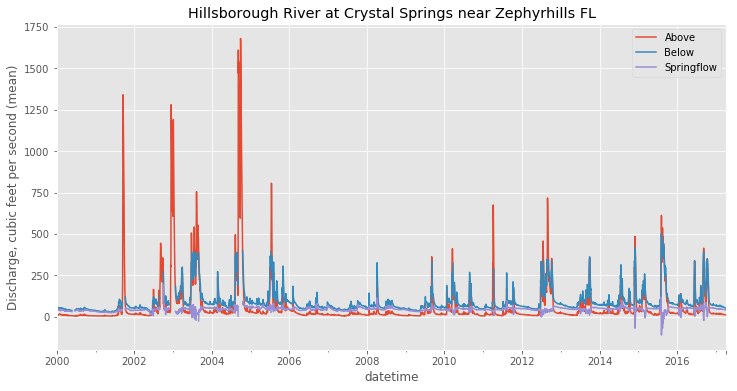

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
title = 'Hillsborough River at Crystal Springs near Zephyrhills FL'
ax.set_ylabel('Discharge, cubic feet per second (mean)')

above.plot(title=title, label='Above')
below.plot(label='Below')
spring.plot(label='Springflow')

plt.legend()
plt.show()

## Plot percent contribution to total flow

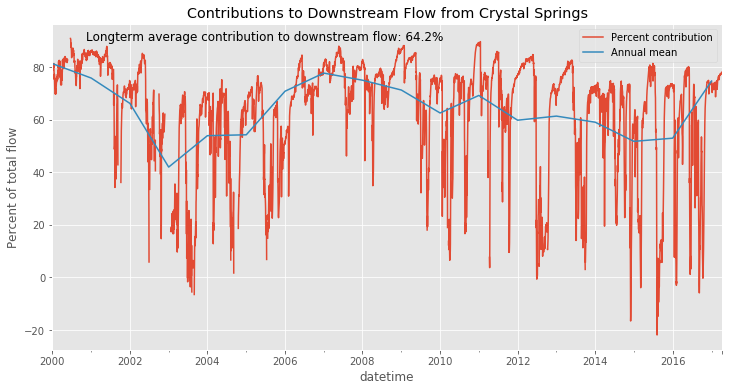

In [7]:
# Create a pyplot object and set title and y-axis label
fig, ax = plt.subplots(figsize=(12, 6))
title = 'Contributions to Downstream Flow from Crystal Springs'
ax.set_ylabel('Percent of total flow')

# Change these to focus on different periods of time
# E.g. '2005' for the year 2005, '2006-01' for January of 2006, or '2006-01-15' for January 15, 2006
# Data were downloaded for the period January 1, 2000 through April 9, 2017 so any period between those
# dates are fair game.
start = '2000'
end = '2017'

pct = (spring[start: end] / below[start: end]) * 100
pct.plot(title=title, label='Percent contribution')
pct.resample('A').mean().plot(label='Annual mean')

# add some text to the plot
s = 'Longterm average contribution to downstream flow: {:.1f}%'.format(pct.mean())
t = ax.text(.05, .95, s, size=12, transform=ax.transAxes)

plt.legend()
plt.show()

## Look at a flow reversal event in August 2015
During a heavy rainfall event, river water flowed back into the spring vent causing a temporary reversal of flow.

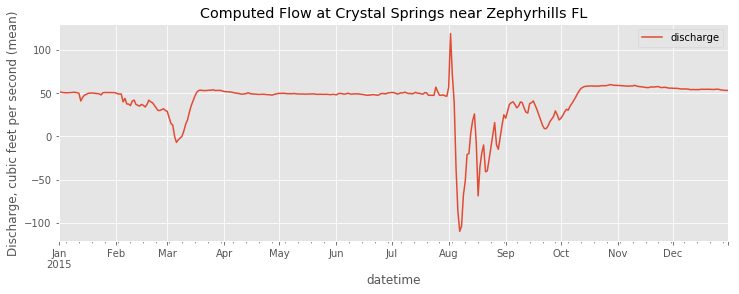

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('Discharge, cubic feet per second (mean)')
title = 'Computed Flow at Crystal Springs near Zephyrhills FL'

spring['2015'].plot(figsize=(12, 4), title=title, legend=True)

plt.show()